# 소득 예측 해커톤
### 김동환, 김명훈, 우동협

---


# 사전 준비

#### 라이브러리 import

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#### 학습 데이터 load

In [73]:
train_data = pd.read_csv("train.csv")

---

## 학습 데이터 전처리

#### 부모의 출신 국가를 대륙으로 매핑
(시각화 이미지)
> 근거 : 출신 국가가 너무 다양함

In [74]:
country_continent_dict = {
 'US': 'US',
 'Cuba': 'North America',
 'Portugal': 'Europe',
 'Mexico': 'North America',
 'Unknown': 'US',
 'Puerto-Rico': 'North America',
 'Germany': 'Europe',
 'Japan': 'Asia',
 'Poland': 'Europe',
 'Columbia': 'South America',
 'Philippines': 'Asia',
 'Italy': 'Europe',
 'Trinadad&Tobago': 'South America',
 'England': 'Europe',
 'South Korea': 'Asia',
 'Iran': 'Asia',
 'France': 'Europe',
 'India': 'Asia',
 'China': 'Asia',
 'Dominican-Republic': 'North America',
 'Scotland': 'Europe',
 'Ecuador': 'South America',
 'Nicaragua': 'North America',
 'Peru': 'South America',
 'Cambodia': 'Asia',
 'Canada': 'North America',
 'Jamaica': 'North America',
 'Vietnam': 'Asia',
 'Hong Kong': 'Asia',
 'Thailand': 'Asia',
 'Haiti': 'North America',
 'Guatemala': 'North America',
 'Laos': 'Asia',
 'Yugoslavia': 'Europe',
 'Ireland': 'Europe',
 'El-Salvador': 'North America',
 'Panama': 'North America',
 'Honduras': 'North America',
 'Greece': 'Europe',
 'Outlying-U S (Guam USVI etc)': 'US',
 'Hungary': 'Europe',
 'Taiwan': 'Asia',
 'Holand-Netherlands': 'Europe'
}
columns_to_update = ['Birth_Country (Mother)', 'Birth_Country (Father)']

for column in columns_to_update:
    train_data[column] = train_data[column].map(country_continent_dict)

#### 본인의 출신 국가를 US와 Others로 분류
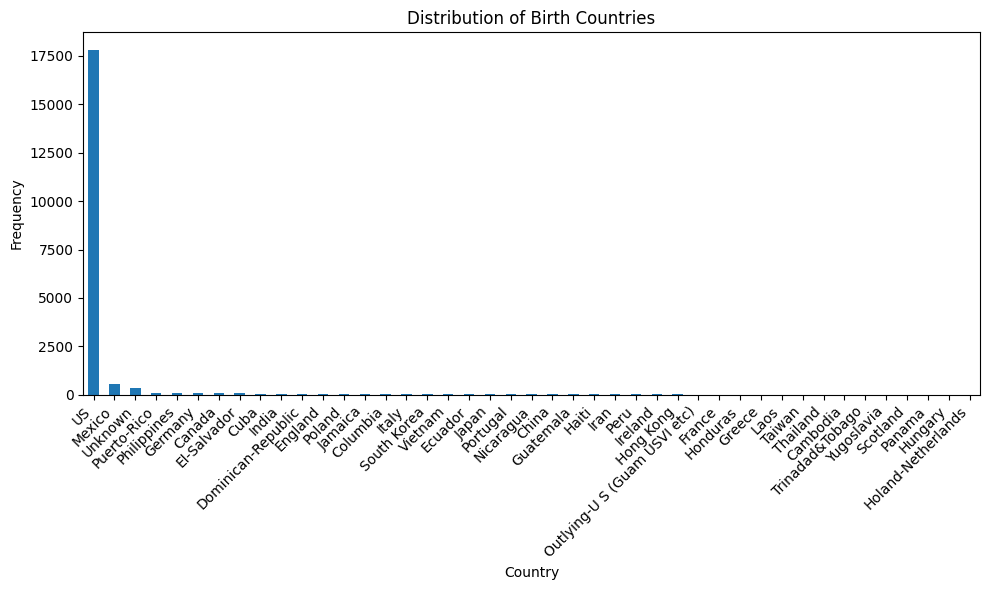
> 근거 : US 출신이 압도적으로 많음

In [75]:
train_data['Birth_Country'] = train_data['Birth_Country'].apply(lambda x: "US" if x == "US" else "Others")

#### 나이가 17~75이외의 값을 지니는 데이터는 제거
(이미지 첨부)
> 근거 : 경제 활동 인구가 아닐 경우 income=0이 압도적으로 많음

In [76]:
train_data = train_data[train_data['Age'].between(17, 75)]

#### Employment Status 열의 값이 'Not Working'이거나 'Seeking Full-Time'인 데이터 제거
(이미지 첨부)
> 근거 : 백수이거나 취준이면 income=0이 압도적으로 많음

In [77]:
train_data = train_data[~train_data['Employment_Status'].isin(['Not Working', 'Seeking Full-Time'])]

### 'Gains', 'Losses', 'Dividends', 'Household_Status', 'Income_Status' 열들을 제거
> 근거 : 유의미한 상관성을 찾지 못함

In [78]:
train_data.drop(['Gains', 'Losses', 'Dividends', 'Household_Status', 'Income_Status'], axis=1, inplace=True)

#### Gender 열에서 성별을 'M' and 'F' 에서 0 과 1로 매핑

In [79]:
train_data['Gender'] = train_data['Gender'].map({'M': 0, 'F': 1})

#### Industry_Status열의 값이 "Armed Forces"이거나 "Not in universe or children"인 데이터 제거

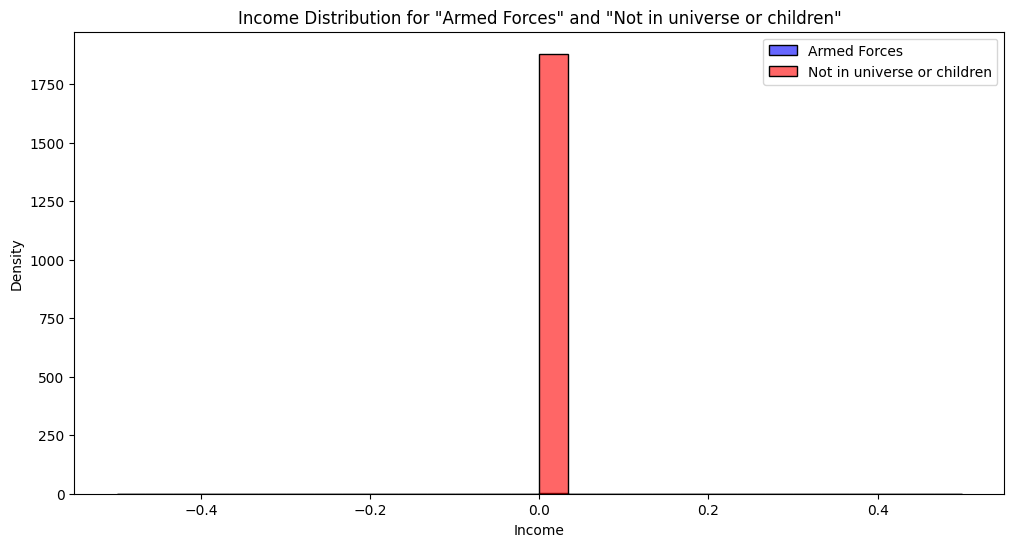
> 근거 : Income=0이 명백하므로

In [80]:
train_data = train_data[~train_data['Industry_Status'].isin(["Armed Forces", "Not in universe or children"])]

#### ID열은 income과 무관하므로 제거

In [81]:

train_data = train_data.drop(columns=['ID'])

#### 'Education_Status'열의 범주의 수가 너무 많아 몇개의 범주로 합쳐 매핑

In [82]:
education_map = {
    'High graduate': 'High', 'High Senior': 'High', 
    'High Junior': 'High', 'High Sophomore': 'High',
    'Elementary (5-6)': 'Elementary(1-6)', 'Elementary (1-4)': 'Elementary(1-6)',
    'Kindergarten': 'Baby', 'Children': 'Baby'
}
train_data['Education_Status'] = train_data['Education_Status'].replace(education_map)

#### 학습시킬 데이터에서 종속변수 income이 이상치(2500이상)를 가지고 있다면 제거

In [83]:
train_data = train_data[train_data['Income'] <= 2400]

#### 학습데이터를 get_dummies메소드를 이용하여 원 핫 인코딩

In [84]:
columns=[
    'Education_Status',
    'Employment_Status',
    'Industry_Status',
    'Occupation_Status',
    'Race',
    'Hispanic_Origin',
    'Martial_Status',
    'Household_Summary',
    'Citizenship',
    'Birth_Country',
    'Birth_Country (Father)',
    'Birth_Country (Mother)',
    'Tax_Status'
]
edit_train_data=pd.get_dummies(train_data,columns=columns,dtype=int)

#### 학습시킬 데이터에 종속변수가 들어있으면 안되므로 제거

In [85]:
edit_train_data = edit_train_data.drop(columns=['Income'])

---


# lightGBM 모델 학습

#### 모델 이용을 위한 기본 세팅

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 데이터 불러오기 edit_train_data는 'Income'열을 drop했으므로 train_data에서 'Income'열을 가져온다.
X = edit_train_data
y = train_data['Income']

# 위의 불러온 train.csv의 전처리를 거친 데이터 셋에서 학습용과 테스트용으로 데이터를 분리한다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 랜덤서치를 통한 하이처파라미터 튜닝

> 랜덤 서치는 하이퍼파라미터 튜닝을 위한 방법 중 하나로, 무작위로 선택된 하이퍼파라미터 조합을 사용하여 모델을 평가  

In [87]:
# LightGBM 모델 생성
lgbm_model = LGBMRegressor()
#랜덤 서치를 위한 파라미터 분포 설정
param_dist = {
    'learning_rate': np.logspace(-3, 0, 100),  # 로그 스케일로 학습률 분포 설정
    'n_estimators': [100, 200, 300, 400, 500],  # 트리의 수
    'max_depth': [3, 5, 7, 9],  # 트리의 최대 깊이
    'num_leaves': [15, 31, 63, 127],  # 각 트리의 최대 잎의 수
    'min_child_samples': [10, 20, 30, 50],  # 각 리프 노드에 필요한 최소 데이터 수
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # 샘플링 비율
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]  # 각 트리를 구성하는 특성의 비율
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=100,  # 시도할 하이퍼파라미터 조합의 수
    cv=5,  # 교차 검증 폴드 수
    scoring='neg_mean_squared_error',  # 평가 지표
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=2,  # 실행 과정 표시
    random_state=42  # 랜덤 시드 고정
)

# 랜덤 서치 수행
random_search.fit(X_train, y_train)

# 최적의 모델 및 파라미터 출력
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 9368, number of used features: 98
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Start training from score 686.242528
[LightGBM] [Info] Number of data points in the train set: 9369, number of used features: 98
[Lig

#### 테스트 데이터에 대한 예측 수행 및 성능 평가

In [88]:

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
# 성능 평가를 위해 rmse와 R²값을 출력한다.
print("RMSE:", rmse)
print("R²:", r2)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE: 519.0974303215373
R²: 0.19077091924537093


/Users/forwarder1121/anaconda3/envs/ossp1-2401/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


---

# 테스트 데이터 전처리

In [89]:
testData = pd.read_csv("test.csv")
# 국가를 대륙으로 매핑하는 딕셔너리
country_continent_dict = {
 'US': 'US',
 'Cuba': 'North America',
 'Portugal': 'Europe',
 'Mexico': 'North America',
 'Unknown': 'US',
 'Puerto-Rico': 'North America',
 'Germany': 'Europe',
 'Japan': 'Asia',
 'Poland': 'Europe',
 'Columbia': 'South America',
 'Philippines': 'Asia',
 'Italy': 'Europe',
 'Trinadad&Tobago': 'South America',
 'England': 'Europe',
 'South Korea': 'Asia',
 'Iran': 'Asia',
 'France': 'Europe',
 'India': 'Asia',
 'China': 'Asia',
 'Dominican-Republic': 'North America',
 'Scotland': 'Europe',
 'Ecuador': 'South America',
 'Nicaragua': 'North America',
 'Peru': 'South America',
 'Cambodia': 'Asia',
 'Canada': 'North America',
 'Jamaica': 'North America',
 'Vietnam': 'Asia',
 'Hong Kong': 'Asia',
 'Thailand': 'Asia',
 'Haiti': 'North America',
 'Guatemala': 'North America',
 'Laos': 'Asia',
 'Yugoslavia': 'Europe',
 'Ireland': 'Europe',
 'El-Salvador': 'North America',
 'Panama': 'North America',
 'Honduras': 'North America',
 'Greece': 'Europe',
 'Outlying-U S (Guam USVI etc)': 'US',
 'Hungary': 'Europe',
 'Taiwan': 'Asia',
 'Holand-Netherlands': 'Europe'
}

# 업데이트할 열 목록: 본인 출신국가, 엄마 출신국가, 아빠 출신국가
columns_to_update = ['Birth_Country', 'Birth_Country (Mother)', 'Birth_Country (Father)']

# 각 열에 대해 국가를 대륙으로 매핑
for column in columns_to_update:
    testData[column] = testData[column].map(country_continent_dict)

testData.drop(['Gains', 'Losses', 'Dividends', 'Household_Status', 'Income_Status'], axis=1, inplace=True)
testData['Gender'] = testData['Gender'].map({'M': 0, 'F': 1})
# 'Education_Status'열의 범주를 합친다.
education_map = {
    'High graduate': 'High', 'High Senior': 'High', 
    'High Junior': 'High', 'High Sophomore': 'High',
    'Elementary (5-6)': 'Elementary(1-6)', 'Elementary (1-4)': 'Elementary(1-6)',
    'Kindergarten': 'Baby', 'Children': 'Baby'
}
testData['Education_Status'] = testData['Education_Status'].replace(education_map)
columns=[
    'Education_Status',
    'Employment_Status',
    'Industry_Status',
    'Occupation_Status',
    'Race',
    'Hispanic_Origin',
    'Martial_Status',
    'Household_Summary',
    'Citizenship',
    'Birth_Country',
    'Birth_Country (Father)',
    'Birth_Country (Mother)',
    'Tax_Status'
]
#제거코드(ID)
testData = testData.drop(columns=['ID'])


#### 실제 제출용 데이터는 행을 제거할 수 없으므로 예측 후 Income이 0이 되기로 판정한 행번호 목록을 작성

In [90]:
row_to_zero = testData[(testData["Age"] < 17) | 
                      (testData["Age"] > 75) | 
                      (testData["Employment_Status"] == "Not Working") | 
                      (testData["Employment_Status"] == "Seeking Full-Time")|
                      (testData['Industry_Status']=="Armed Forces")|
                      (testData['Industry_Status']=="Not in universe or children")].index

#### 범주형 데이터를 담은 열들에 대해 train에는 있고 test에는 없는 범주가 있어 원핫 인코딩 시 열의 갯수가 맞지 않는 에러가 발생하여 모델이 입력받지 못하므로 에러처리 

In [91]:
# 'df_encoded'는 훈련 데이터에 대해 이미 원핫 인코딩이 수행된 DataFrame이다.
# 'train_cols'는 원핫 인코딩된 훈련 데이터의 열 순서이다.
train_cols = edit_train_data.columns

# 'columns' 리스트에 지정된 열에 대해 testData 데이터프레임을 원핫 인코딩한다.
edited_testData = pd.get_dummies(testData, columns=columns, dtype=int)

# 훈련 데이터에만 있는 열을 찾는다.
missing_cols = set(train_cols) - set(edited_testData.columns)

# 훈련 데이터에만 있는 열을 테스트 데이터에 추가하고, 해당 열의 값을 0으로 설정한다.
for col in missing_cols:
    edited_testData[col] = 0

# 테스트 데이터에서 훈련 데이터에 없는 열을 찾는니다.
extra_cols = set(edited_testData.columns) - set(train_cols)

# 테스트 데이터에서 훈련 데이터에 없는 열을 제거한다.
edited_testData = edited_testData.drop(columns=extra_cols)

# 테스트 데이터의 열 순서를 훈련 데이터의 열 순서와 동일하게 재정렬한다.
edited_testData = edited_testData[train_cols]

# 이제 'edited_testData'는 원핫 인코딩된 테스트 데이터이며, 열 순서가 'df_encoded'와 일치한다.


---

# LightGBM 모델을 이용한 예측

#### 모델을 이용해 결과를 산추하고 0으로 판정하기로한 행과 예측값이 음수인 행들의 값을 전부 0으로 처리

In [92]:
y_pred_lightGBM = best_model.predict(edited_testData) 
for i in range(len(y_pred_lightGBM)):
    if i in row_to_zero:
        y_pred_lightGBM[i]=0
y_pred_lightGBM[y_pred_lightGBM < 0] = 0

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


#### 제출 파일 산출

In [93]:
# ID 생성
ids = [f'TEST_{i:04d}' for i in range(len(y_pred_lightGBM))]

# 데이터프레임 생성
df = pd.DataFrame({
    'ID': ids,
    'Income': y_pred_lightGBM
})

# CSV 파일로 저장
df.to_csv('submissionFilelightGBM.csv', index=False)